In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from solarposition import *
from shadowingfunction_wallheight_13 import shadowingfunction_wallheight_13

# Load Numpy array

In [90]:
# dsm is a map that reprents elevation information 
dsm = np.load('./dsm_local_array.npy')
dsm = np.nan_to_num(dsm, nan=0)

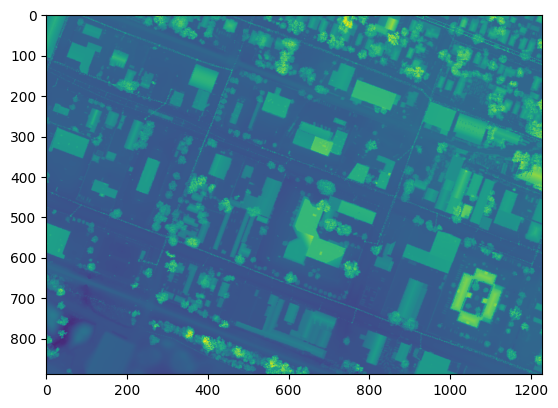

In [91]:
f, ax = plt.subplots()

plt.imshow(dsm, cmap='viridis')

plt.show()

# Sun's position

In [92]:
# Sun position
# https://github.com/pvlib/pvlib-python

lon = -95.30052
lat = 29.73463

utc_offset= -6

# Create a date range from 6:00 to 20:00 with a 10-minute interval
timestamps = pd.date_range('2023-09-12 11:00', '2023-09-12 11:10', freq='30T')

# Create a DataFrame using the timestamps as a column
df_solar_data = pd.DataFrame({'TimeStamp': timestamps})



# UTC time
df_solar_data['TimeStamp'] = pd.DatetimeIndex(df_solar_data['TimeStamp']) - pd.DateOffset(hours=utc_offset)

# To_Datetime
df_solar_data["TimeStamp"] = df_solar_data["TimeStamp"].apply(pd.to_datetime)
df_solar_data.set_index("TimeStamp", inplace = True)

# Add time index
df_solar_data["TimeStamp"] = df_solar_data.index

df_solar_data.head()

,TimeStamp
TimeStamp,
2023-09-12 17:00:00,2023-09-12 17:00:00


In [93]:
# Get_sun's position df
df_solar = get_solarposition(df_solar_data.index, lat, lon)

# Add time index
df_solar['TimeStamp'] = pd.DatetimeIndex(df_solar.index) + pd.DateOffset(hours=utc_offset)

df_solar = df_solar[['TimeStamp', 'apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
                   'azimuth', 'equation_of_time']]

# To_Datetime
df_solar["TimeStamp"] = df_solar["TimeStamp"].apply(pd.to_datetime)
df_solar.set_index("TimeStamp", inplace = True)

df_solar.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
TimeStamp,,,,,,
2023-09-12 11:00:00,31.513944,31.524265,58.486056,58.475735,140.740018,3.713015


In [94]:
df_solar["TimeStamp"] = df_solar.index
df_solar = df_solar[['TimeStamp', 'elevation', 'zenith', 'azimuth']]

df_solar = df_solar.rename(columns={"elevation": "Elevation","azimuth": "Azimuth", "zenith": "Zenith"})

df_solar.head()

,TimeStamp,Elevation,Zenith,Azimuth
TimeStamp,,,,
2023-09-12 11:00:00,2023-09-12 11:00:00,58.475735,31.524265,140.740018


# Walls and Height

In [95]:
# Temporally !
scale = 1
# walls = np.zeros((dsm.shape[0], dsm.shape[1]))
# dirwalls = np.zeros((dsm.shape[0], dsm.shape[1]))

# walls.shape

# Shadow

In [96]:
import requests
import json

def calculate_shadow(df_solar):
    i = 0
    scale = 1

    altitude = df_solar['Elevation'][i]
    azimuth = df_solar['Azimuth'][i]

    hour = df_solar.index[i].hour
    minute = df_solar.index[i].minute

    print(hour, minute)

    # API endpoint for calculating shadow 
    url = 'http://ec2-35-173-183-116.compute-1.amazonaws.com:5001/api/v1/shadow_analysis/calculate-shadow'

    dsm = np.load('./dsm_local_array.npy')
    dsm = np.nan_to_num(dsm, nan=0)

    print(dsm.shape)
    data = {
        'azimuth': azimuth,
        'altitude': altitude,
        'scale':scale,
        'dsm': dsm.tolist()
    }

    data_headers = {'Content-type': 'application/json'}

    print('Headers:', data_headers)

    # Make a POST request to the API
    response = requests.post(url, json=data, headers=data_headers, timeout=200)

    # Print the status code and the response JSON
    print('Status code:', response.status_code)

    if response.status_code == 200:
        print('Response JSON:', json.dumps(response.json(), indent=4))
        return response.json()
    else:
        print('Failed to retrieve data')

In [97]:
result = calculate_shadow(df_solar)
print(result)

/var/folders/41/0vrjgmqn3v1c0_7mns_bvqpm0000gn/T/ipykernel_40603/2185197845.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  altitude = df_solar['Elevation'][i]
/var/folders/41/0vrjgmqn3v1c0_7mns_bvqpm0000gn/T/ipykernel_40603/2185197845.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  azimuth = df_solar['Azimuth'][i]


11 0
(889, 1228)
Headers: {'Content-type': 'application/json'}
Status code: 200
Response JSON: {
    "id": "fc6bf79f-24d9-494f-80ae-0abf5960a1f1",
    "message": "Shadow analysis completed and stored in MongoDB"
}
{'id': 'fc6bf79f-24d9-494f-80ae-0abf5960a1f1', 'message': 'Shadow analysis completed and stored in MongoDB'}


In [98]:

#get data from mongodb and plot the data using matplot lib
url = 'http://ec2-35-173-183-116.compute-1.amazonaws.com:5001/api/v1/shadow_analysis/get-shadow-data'
data_headers = {'Content-type': 'application/json'}
print("Getting shadow data for document:",result["id"])
data = {"document_id":result["id"]}
# Make a POST request to the API
response = requests.post(url, json=data, headers=data_headers, timeout=200)
response_json = response.json()
shadow_data = response_json.get("shadow_data")
sh = shadow_data["sh"]

Getting shadow data for document: fc6bf79f-24d9-494f-80ae-0abf5960a1f1


Visualising Shadow Data...


Text(0.5, 1.0, '23:19')

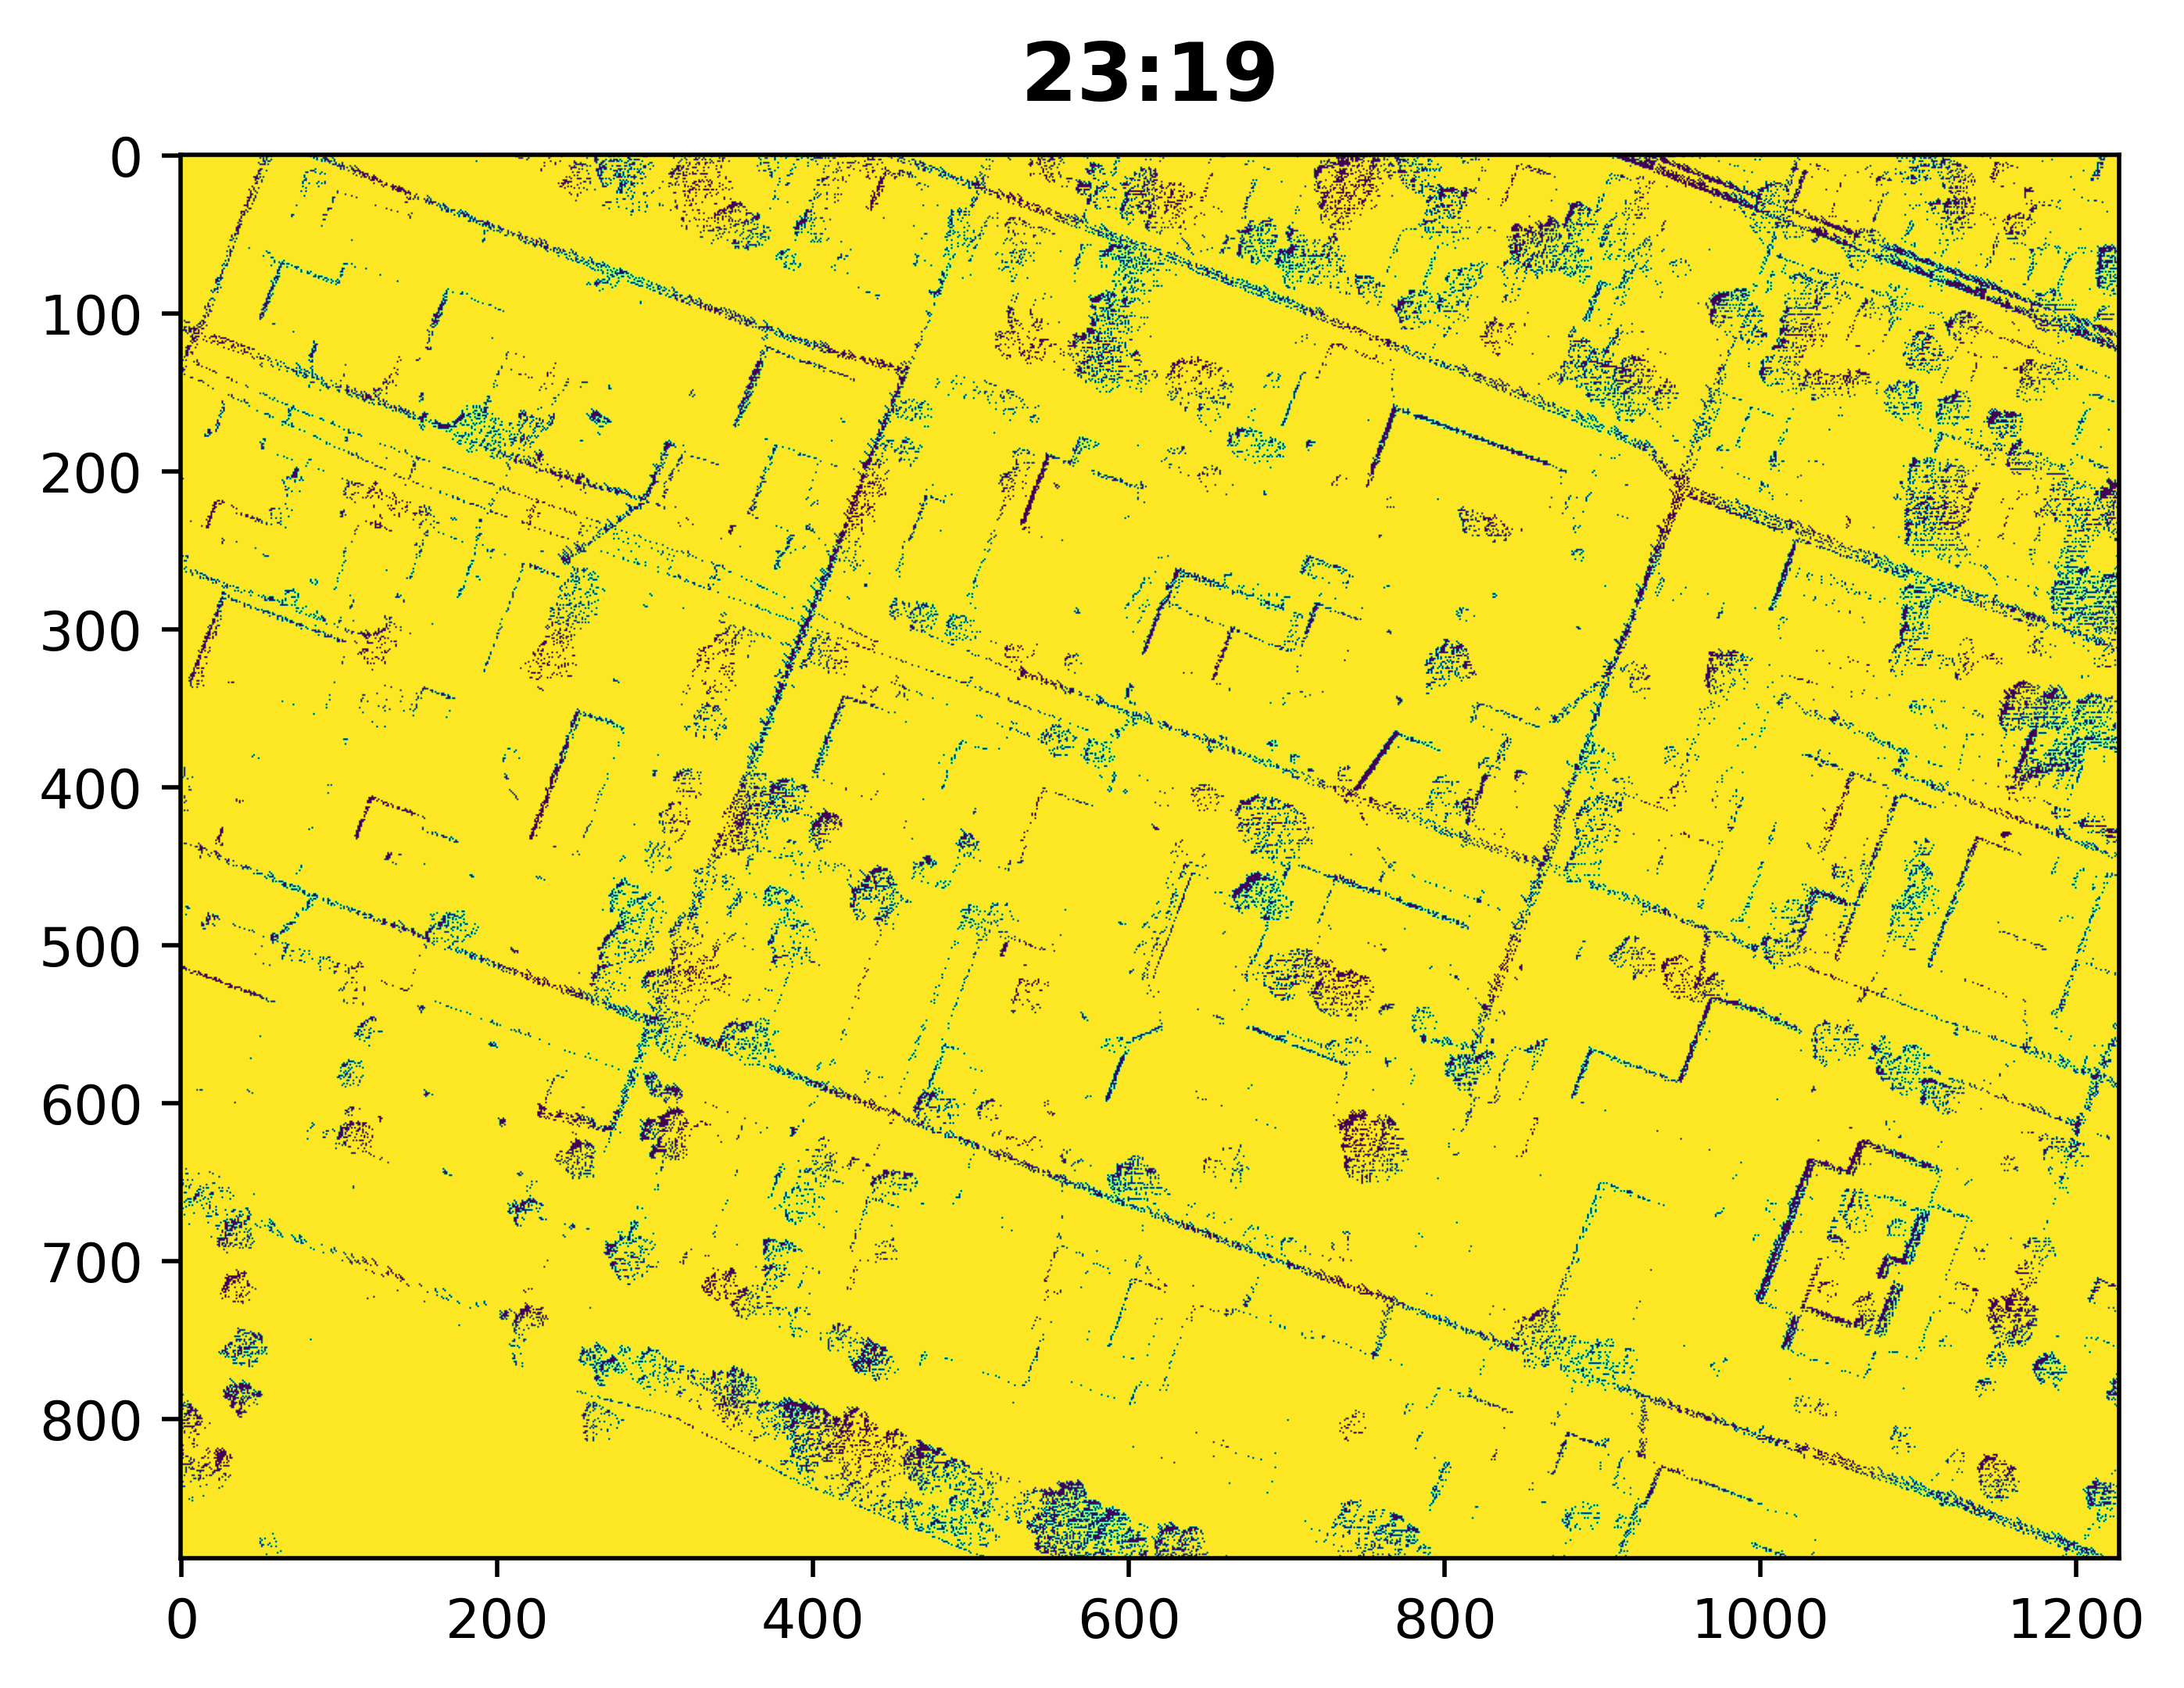

In [99]:
from datetime import datetime
print("Visualising Shadow Data...")
timestamp_str = shadow_data.get("timestamp")
timestamps = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%f")
hour = timestamps.hour
minute = timestamps.minute
f, ax = plt.subplots(dpi=500)

plt.imshow(sh, cmap='viridis')

plt.title("%2s" % str(hour).zfill(2) + ":%2s"% str(minute).zfill(2), pad =10, fontsize=15, color="black", weight='bold' )